## Feature engineering of the titanic dataset

In [1]:
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import cross_val_score, GridSearchCV, RandomizedSearchCV
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv("titanic/train.csv")

In [3]:
# Check which columns have NaN values
data.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
dtype: bool

<Axes: xlabel='Sex'>

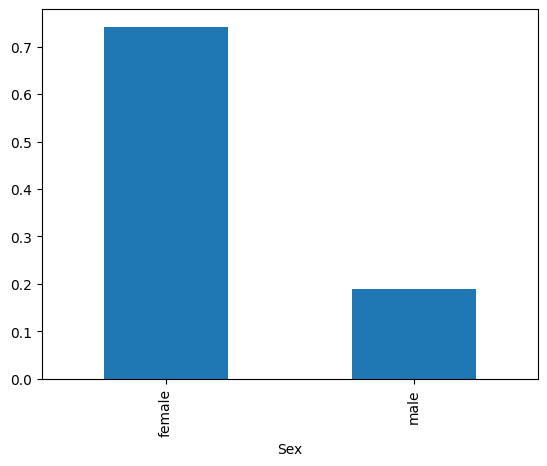

In [5]:
data["Survived"].groupby(data["Sex"]).mean().plot(kind="bar")

In [6]:
print('\n\nSex Ratio of Passengers in %')
print(data['Sex'].value_counts(normalize=True))

print('\n\nSurviving passengers by sex in %')
print(data['Survived'].groupby(data['Sex']).mean())



Sex Ratio of Passengers in %
Sex
male      0.647587
female    0.352413
Name: proportion, dtype: float64


Surviving passengers by sex in %
Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64


In [7]:
# Get the title out of the Name column and create a Title column
data[["LastName", "Rest"]] = data["Name"].str.split(", ", expand=True)
data["Title"] = data["Rest"].str.split(".", expand=True)[0]
print(data["Title"].value_counts())

# Map the Title column to some nobility(or not) values
status_map = {"Mr": "Common",
              "Miss": "Common",
              "Mrs": "Common",
              "Master": "Common",
              "Dr": "Dr", 
              "Rev": "Clergy", 
              "Col": "Military",
              "Mlle": "Common", 
              "Major": "Military",
              "Ms": "Common",
              "Mme": "Common",
              "Don": "Noble",
              "Lady": "Noble",
              "Sir": "Noble",
              "Capt": "Military",
              "the Countess": "Noble",
              "Jonkheer": "Noble"}

data["Title"] = data["Title"].map(status_map)
print(data["Title"])

Title
Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Ms                1
Mme               1
Don               1
Lady              1
Sir               1
Capt              1
the Countess      1
Jonkheer          1
Name: count, dtype: int64
0      Common
1      Common
2      Common
3      Common
4      Common
        ...  
886    Clergy
887    Common
888    Common
889    Common
890    Common
Name: Title, Length: 891, dtype: object


<Axes: xlabel='Title'>

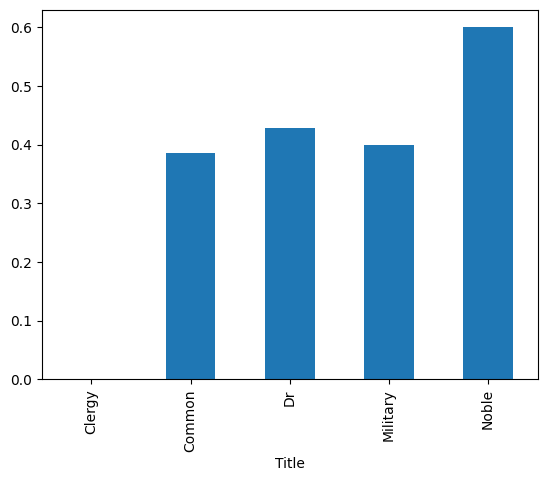

In [8]:
data["Survived"].groupby(data["Title"]).mean().plot(kind="bar")

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64


np.True_

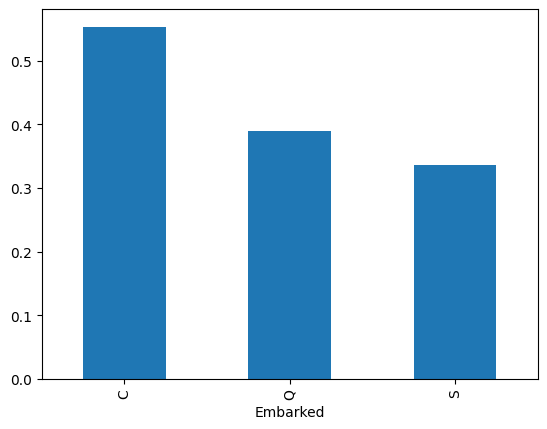

In [9]:
# Check if the Embarking site has any impact in survival rate (apparently it does)
print(data["Embarked"].value_counts())
data["Survived"].groupby(data["Embarked"]).mean().plot(kind="bar")
data["Embarked"].isnull().any()

In [10]:
# Add both columns Parch and SibSp, as they describe parents and siblings on board, respectively
data["Family"] = data["Parch"]+data["SibSp"]
print(data["Family"])

0      1
1      1
2      0
3      1
4      0
      ..
886    0
887    0
888    3
889    0
890    0
Name: Family, Length: 891, dtype: int64


In [11]:
data["Age"] = data["Age"].fillna(data["Age"].mean())

In [12]:
# Lets check again which columns have null values (CABIN has a lot)
data.isnull().any()

PassengerId    False
Survived       False
Pclass         False
Name           False
Sex            False
Age            False
SibSp          False
Parch          False
Ticket         False
Fare           False
Cabin           True
Embarked        True
LastName       False
Rest           False
Title          False
Family         False
dtype: bool

In [13]:
# Mapping remaining literal columns to numerical
sex_to_map = {"male": 0, 
              "female": 1}
data["Sex"] = data["Sex"].map(sex_to_map)

embark_to_map = {"S": 0, 
                 "C": 1, 
                 "Q":2}
data["Embarked"] = data["Embarked"].map(embark_to_map)

title_to_map = {"Common": 1,
                "Noble": 2, 
                "Dr": 1,
                "Clergy": 0,
                "Military": 1}
data["Title"] = data["Title"].map(title_to_map)


In [14]:
# Lets drop unnecessary columns
features_to_drop = ["PassengerId", "Survived", "Name", "SibSp", "Parch", "Ticket", "Cabin", "Rest", "LastName"]

In [15]:
# Set 20% for testing and 80% for training/validation
x_test = data.sample(frac=0.20, random_state=42)
x_train = data.drop(x_test.index)  # just drop the indexes from x_test

# Get the labels for the train and test portions
y_test = x_test["Survived"]
y_train = x_train["Survived"]


In [16]:
x_train = x_train.drop(features_to_drop, axis=1)
x_test = x_test.drop(features_to_drop, axis=1)

print(x_train.head())
print(x_test.head())

   Pclass  Sex   Age     Fare  Embarked  Title  Family
0       3    0  22.0   7.2500       0.0      1       1
1       1    1  38.0  71.2833       1.0      1       1
2       3    1  26.0   7.9250       0.0      1       0
3       1    1  35.0  53.1000       0.0      1       1
4       3    0  35.0   8.0500       0.0      1       0
     Pclass  Sex        Age     Fare  Embarked  Title  Family
709       3    0  29.699118  15.2458       1.0      1       2
439       2    0  31.000000  10.5000       0.0      1       0
840       3    0  20.000000   7.9250       0.0      1       0
720       2    1   6.000000  33.0000       0.0      1       1
39        3    1  14.000000  11.2417       1.0      1       1


In [17]:
X = x_train
y = y_train

In [18]:
def find_best_params_Forest_grid_search(x_train, y_train):
    param_grid = {"n_estimators":range(70, 130), "max_depth": range(1,20), "min_samples_split": range(2,15), 
                  "max_features": ["sqrt", "log2", None]}
    grid_search = RandomizedSearchCV(RandomForestClassifier(), param_grid, cv=5, verbose=1)
    grid_search.fit(x_train, y_train)
    best_depth = grid_search.best_params_["max_depth"]
    n_estimators = grid_search.best_params_["n_estimators"]
    max_features = grid_search.best_params_["max_features"]
    min_split = grid_search.best_params_["min_samples_split"]

    return n_estimators, best_depth, min_split, max_features

In [19]:
# Find the best depth, you can use grid search or a more simple CV approach
n_estimators, best_depth, min_samples_split, max_features = find_best_params_Forest_grid_search(X, y)
print("Best fit found at depth:", best_depth)
print("Best fit found at n_estimators:", n_estimators)
print("Best fit found at min_samples_split:", min_samples_split)
print("Best fit found at max_features:", max_features)

# Use the best hyperparameters, found by using RandomizedSearchCV, with CV=5
d_tree = RandomForestClassifier(n_estimators=n_estimators, max_depth=best_depth,
                                min_samples_split=min_samples_split, max_features=max_features)
d_tree = d_tree.fit(X, y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best fit found at depth: 12
Best fit found at n_estimators: 107
Best fit found at min_samples_split: 14
Best fit found at max_features: None


In [20]:
# Test on the test subset we set apart at the beginning
y_pred = d_tree.predict(x_test)
# Print some stats for both classes
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       105
           1       0.81      0.71      0.76        73

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



## Lets load the Kaggle dataset and test our naive model

In [24]:
kaggle_data = pd.read_csv("titanic/test.csv")

In [25]:
# Get the title out of the Name column and create a Title column
kaggle_data[["LastName", "Rest"]] = kaggle_data["Name"].str.split(", ", expand=True)
kaggle_data["Title"] = kaggle_data["Rest"].str.split(".", expand=True)[0]
print(kaggle_data["Title"].value_counts())

# Map the Title column to some nobility(or not) values
status_map = {"Mr": "Common",
              "Miss": "Common",
              "Mrs": "Common",
              "Master": "Common",
              "Dr": "Dr", 
              "Rev": "Clergy", 
              "Col": "Military",
              "Mlle": "Common", 
              "Major": "Military",
              "Ms": "Common",
              "Mme": "Common",
              "Don": "Noble",
              "Lady": "Noble",
              "Sir": "Noble",
              "Capt": "Military",
              "the Countess": "Noble",
              "Jonkheer": "Noble"}

kaggle_data["Title"] = kaggle_data["Title"].map(status_map)
print(kaggle_data["Title"])

Title
Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Ms          1
Dr          1
Dona        1
Name: count, dtype: int64
0      Common
1      Common
2      Common
3      Common
4      Common
        ...  
413    Common
414       NaN
415    Common
416    Common
417    Common
Name: Title, Length: 418, dtype: object


In [26]:
# Merge Parch and SibSp
kaggle_data["Family"] = kaggle_data["Parch"]+kaggle_data["SibSp"]
print(kaggle_data["Family"])

0      0
1      1
2      0
3      0
4      2
      ..
413    0
414    0
415    0
416    0
417    2
Name: Family, Length: 418, dtype: int64


In [27]:
kaggle_data["Age"] = kaggle_data["Age"].fillna(kaggle_data["Age"].mean())

In [28]:
# Lets drop unnecessary columns
kaggle_features_to_drop = ["PassengerId", "Name", "SibSp", "Parch", "Ticket", "Cabin", "Rest", "LastName"]

In [29]:
kaggle_data = kaggle_data.drop(kaggle_features_to_drop, axis=1)
print(kaggle_data)

     Pclass     Sex       Age      Fare Embarked   Title  Family
0         3    male  34.50000    7.8292        Q  Common       0
1         3  female  47.00000    7.0000        S  Common       1
2         2    male  62.00000    9.6875        Q  Common       0
3         3    male  27.00000    8.6625        S  Common       0
4         3  female  22.00000   12.2875        S  Common       2
..      ...     ...       ...       ...      ...     ...     ...
413       3    male  30.27259    8.0500        S  Common       0
414       1  female  39.00000  108.9000        C     NaN       0
415       3    male  38.50000    7.2500        S  Common       0
416       3    male  30.27259    8.0500        S  Common       0
417       3    male  30.27259   22.3583        C  Common       2

[418 rows x 7 columns]


In [30]:
x_test = kaggle_data

In [31]:
# Mapping remaining literal columns to numerical
sex_to_map = {"male": 0, 
              "female": 1}
x_test["Sex"] = x_test["Sex"].map(sex_to_map)

embark_to_map = {"S": 0, 
                 "C": 1, 
                 "Q":2}
x_test["Embarked"] = x_test["Embarked"].map(embark_to_map)

title_to_map = {"Common": 1,
                "Noble": 2, 
                "Dr": 1,
                "Clergy": 0,
                "Military": 1}
x_test["Title"] = x_test["Title"].map(title_to_map)

In [32]:
print(x_test)

     Pclass  Sex       Age      Fare  Embarked  Title  Family
0         3    0  34.50000    7.8292         2    1.0       0
1         3    1  47.00000    7.0000         0    1.0       1
2         2    0  62.00000    9.6875         2    1.0       0
3         3    0  27.00000    8.6625         0    1.0       0
4         3    1  22.00000   12.2875         0    1.0       2
..      ...  ...       ...       ...       ...    ...     ...
413       3    0  30.27259    8.0500         0    1.0       0
414       1    1  39.00000  108.9000         1    NaN       0
415       3    0  38.50000    7.2500         0    1.0       0
416       3    0  30.27259    8.0500         0    1.0       0
417       3    0  30.27259   22.3583         1    1.0       2

[418 rows x 7 columns]


In [33]:
# Predict with the random forest classifier
y_pred = d_tree.predict(x_test)

# Save the predictions to a csv file
prediction = pd.DataFrame(y_pred, columns=['Survived']).to_csv('titanic_predictions.csv')